Figure out actual priority dates of patents

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [2]:
master = pd.read_csv('data/master_503107.csv')

related = pd.read_csv('data/usreldoc.tsv', delimiter='\t'\
            , usecols=['patent_id','doctype','relkind','reldocno','sequence'])

First, figure out the earliest date for each patent for continuations

In [3]:
related.head()

,patent_id,doctype,relkind,reldocno,sequence
0,8501207,continuation-in-part,child-doc,09969456,10
1,7519253,us-provisional-application,NaN,60738389,0
2,8045312,continuation,child-doc,12477790,2
3,8622319,continuation,parent-doc,11009621,0
4,8706267,division,parent-grant-document,7444191,1


In [4]:
related.relkind.unique()

array(['child-doc', nan, 'parent-doc', 'parent-grant-document',
       'parent_grant_document', 'parent-pct-document', 'parent_doc',
       'child_doc', 'parent_pct_document'], dtype=object)

In [5]:
related.dropna(axis=0, subset=['relkind'],inplace=True)

#only care about granted patents and patents in our master list
related = related.loc[(related.relkind.str.contains('grant'))\
                      & (related.patent_id.isin(master.patent_number.tolist()))]

In [6]:
related = related.sort_values(['patent_id','reldocno','sequence'])\
.drop_duplicates(subset=['patent_id','reldocno'], keep='last')

In [7]:
# find last child patent and distill the parents through them.
# In order to prevent overlapping families that should belong togther, dont select patents that are listed
# in both patent_id and relateddocno
patent_fam = related.loc[~related.patent_id.isin(related.reldocno.tolist())]

Text(0.5,0,'family size')

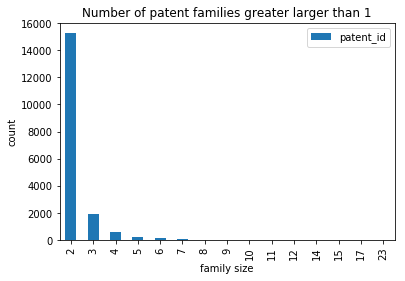

In [8]:
ax = patent_fam.groupby('patent_id')['sequence'].count().apply(lambda x: x + 1).reset_index()\
.groupby('sequence').count().plot(kind='bar', title='Number of patent families greater larger than 1')
ax.set_ylabel('count')
ax.set_xlabel('family size')

In [9]:
#patents with families size n=1
patent_fam_list = list(set(patent_fam.patent_id.tolist() + patent_fam.reldocno.tolist()))

master.loc[~master.patent_number.isin(patent_fam_list)]
master['family_size'] = np.where(~master.patent_number.isin(patent_fam_list), '1', '2+')

Text(0,0.5,'')

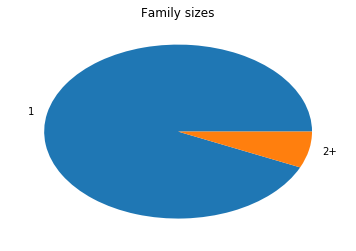

In [10]:
ax = master.groupby('family_size')['patent_number'].count().plot.pie()
ax.set_title('Family sizes')
ax.set_ylabel('')

In [11]:
master.family_size.value_counts(normalize=True)

1     0.932438
2+    0.067562
Name: family_size, dtype: float64

In these patent families, calcuate the priority date by selecting the application date of the earliest related doc
Which will usually have the largest sequence number

In [12]:
seeds = patent_fam.iloc[patent_fam.reset_index().groupby(['patent_id'])['sequence'].idxmax()]
seeds.head()

,patent_id,doctype,relkind,reldocno,sequence
8053117,D452639,continuation,parent_grant_document,D406740,5
4368177,D452642,division,parent_grant_document,D439143,5
8231682,D452660,division,parent_grant_document,D446140,5
2749899,D452675,continuation,parent_grant_document,D427138,13
4019899,D452691,division,parent_grant_document,D443622,5


Now to select the application years of these seed patents

In [13]:
seeds.loc[seeds.duplicated('reldocno',keep=False)].sort_values('patent_id')

,patent_id,doctype,relkind,reldocno,sequence
2749899,D452675,continuation,parent_grant_document,D427138,13
3562390,D452925,division,parent_grant_document,D442888,5
5942129,D452972,division,parent_grant_document,D436978,5
4824163,D453402,continuation_in_part,parent_grant_document,5950330,41
5378907,D453588,continuation_in_part,parent_grant_document,D445024,8
5896051,D453589,continuation_in_part,parent_grant_document,D445024,8
3030974,D453692,continuation_in_part,parent_grant_document,D444079,2
7312992,D453719,division,parent_grant_document,D452460,2
7415054,D453721,division,parent_grant_document,D442888,2
3560854,D453942,division,parent_grant_document,D436978,2


In [14]:
seeds.patent_id.nunique()

18289

In [15]:
seeds.reldocno.nunique()

13559

Seems as if some of the patents share a parent, which makes them sister patents. Patent families may be larger than expected. Recalulate patent families to include these sister patents to see if it makes a difference

Text(0.5,0,'family size')

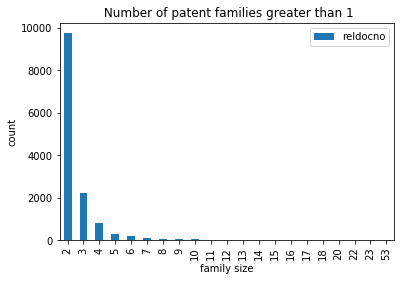

In [16]:
seed_list = list(seeds.reldocno.unique())
ax = related.loc[related.reldocno.isin(seed_list)]\
.groupby('reldocno')['sequence']\
.count()\
.apply(lambda x: x+ 1)\
.reset_index()\
.groupby('sequence')\
.count()\
.plot(kind='bar', title =' Number of patent families greater than 1')
ax.set_ylabel('count')
ax.set_xlabel('family size')

Now let's calculate the application years of these seeds

Select application data we already have

In [17]:
seed_list = list(seeds.reldocno.unique())
seed_app_years_already_have = master.loc[master.patent_number.isin(seed_list)][['patent_number','app_year']]

In [18]:
seed_app_years_already_have.shape

(12445, 2)

Calculate application years of seed patents - will gather this data from the data using data pulling file

In [19]:
seeds_needs = list(seeds.loc[~seeds.reldocno.isin(master.patent_number.tolist())].reldocno.unique())

In [20]:
file_Name = "seeds_need"
# open the file for writing
fileObject = open(file_Name,'wb') 

# this writes the object a to the
# file named 'testfile'
pickle.dump(seeds_needs,fileObject)   

# here we close the fileObject
fileObject.close()

Pulled the application data for the seed patents from the unavailable patents

In [21]:
seed_app_years_did_not_have = pd.read_csv('data/seeds_need_app_years.csv')

In [22]:
seed_app_years_did_not_have.shape[0] + seed_app_years_already_have.shape[0]

13556

In [23]:
seed_years = seed_app_years_already_have.append(seed_app_years_did_not_have, ignore_index=True)

# Recalibrate priority year based off calculations above

assign priority year of patents in the same family to the oldest patent

In [24]:
#merging dates up to master data frame
seeds = pd.merge(seeds, seed_years, left_on = 'reldocno', right_on = 'patent_number')
seeds.head()

,patent_id,doctype,relkind,reldocno,sequence,patent_number,app_year
0,D452639,continuation,parent_grant_document,D406740,5,D406740,1997
1,D452642,division,parent_grant_document,D439143,5,D439143,2000
2,D452660,division,parent_grant_document,D446140,5,D446140,1999
3,D452675,continuation,parent_grant_document,D427138,13,D427138,1997
4,D464605,division,parent_grant_document,D427138,9,D427138,1997


In [25]:
seeds.head()

,patent_id,doctype,relkind,reldocno,sequence,patent_number,app_year
0,D452639,continuation,parent_grant_document,D406740,5,D406740,1997
1,D452642,division,parent_grant_document,D439143,5,D439143,2000
2,D452660,division,parent_grant_document,D446140,5,D446140,1999
3,D452675,continuation,parent_grant_document,D427138,13,D427138,1997
4,D464605,division,parent_grant_document,D427138,9,D427138,1997


In [26]:
patent_fam.head()

,patent_id,doctype,relkind,reldocno,sequence
8053117,D452639,continuation,parent_grant_document,D406740,5
4368177,D452642,division,parent_grant_document,D439143,5
8231682,D452660,division,parent_grant_document,D446140,5
2749899,D452675,continuation,parent_grant_document,D427138,13
4019899,D452691,division,parent_grant_document,D443622,5


In [27]:
patent_fam = pd.merge(seeds[['patent_id','app_year']], patent_fam, on='patent_id')
patent_fam.head()

,patent_id,app_year,doctype,relkind,reldocno,sequence
0,D452639,1997,continuation,parent_grant_document,D406740,5
1,D452642,2000,division,parent_grant_document,D439143,5
2,D452660,1999,division,parent_grant_document,D446140,5
3,D452675,1997,continuation,parent_grant_document,D427138,13
4,D464605,1997,division,parent_grant_document,D427138,9


In [28]:
# apply priority date of the patent number matches the patent id or related doc no
master = pd.merge(master,patent_fam.drop_duplicates(subset=['patent_id'])[['patent_id','app_year']],\
                  left_on='patent_number', right_on='patent_id', how='left')

master = pd.merge(master,patent_fam.drop_duplicates(subset=['reldocno'])[['reldocno','app_year']],\
                  left_on='patent_number', right_on='reldocno', how='left')

master.head()

,patent_number,grant_year,app_year_x,num_inventors,us_inventor,cite_foreign_patent,is_missing,num_design_cited,num_utility_cited,non-pat_refs,num_figures,num_assignees,missing_data,family_size,country_transformed,priority_year,patent_id,app_year_y,reldocno,app_year
0,D257752,1981,1980,1,1,0,1,1,2,1,6,1,0,1,US,1980,NaN,NaN,NaN,NaN
1,D257924,1981,1980,1,1,0,1,1,2,1,6,1,0,1,US,1980,NaN,NaN,NaN,NaN
2,D258382,1981,1980,2,1,0,1,2,1,0,5,1,0,1,US,1980,NaN,NaN,NaN,NaN
3,D258383,1981,1980,2,1,0,1,2,1,0,5,1,0,1,US,1980,NaN,NaN,NaN,NaN
4,D258678,1981,1980,2,1,0,1,2,1,0,5,1,0,1,US,1980,NaN,NaN,NaN,NaN


Note: app_year_x is the original application date, app_year_y and app_year are priority dates based on lineage, based on which column it was merged with. Will be cleaned up later

Apply foreign priority date

In [29]:
foreign = pd.read_csv('data/foreign_priority.tsv', delimiter='\t',\
                      usecols=['patent_id','date','country_transformed'])
foreign.head()

,patent_id,date,country_transformed
0,4579440,1982-11-18,JP
1,4736480,1985-03-27,DE
2,D449111,2001-01-09,HK
3,5228311,1990-08-16,DE
4,9711226,2015-03-04,JP


In [30]:
foreign.loc[foreign.patent_id.str.match('D262768')]

,patent_id,date,country_transformed
428779,D262768,1979-11-29,GB


In [28]:
foreign.loc[foreign.duplicated(subset=['patent_id'], keep=False)].sort_values('patent_id').head()

,patent_id,date,country_transformed
2471942,3930292,1974-07-06,DT
537012,3930292,1974-02-08,DT
2738273,3930313,1974-07-03,FR
906044,3930313,1973-09-14,FR
2205889,3930319,1974-08-23,AU


Some patents have multiple dates, choose the earliest one

In [35]:
# foreign['foreign_year'] = pd.to_datetime(foreign.date, errors='coerce').dt.year

# foreign = foreign.loc[foreign.patent_id.isin(master.patent_number.tolist())].dropna(subset=['foreign_year'])

# foreign = foreign.iloc[foreign.reset_index().groupby('patent_id')['foreign_year'].idxmin()]

master = pd.merge(master, foreign, left_on='patent_number', right_on='patent_id', how='left')

In [36]:
foreign.loc[foreign.patent_id.str.match('D262768')]

,patent_id,date,country_transformed,foreign_year
428779,D262768,1979-11-29,GB,1979.0


In [37]:
master.head()

,patent_number,grant_year,app_year_x,num_inventors,us_inventor,cite_foreign_patent,is_missing,num_design_cited,num_utility_cited,non-pat_refs,...,country_transformed_x,priority_year,patent_id_x,app_year_y,reldocno,app_year,patent_id_y,date,country_transformed_y,foreign_year
0,D257752,1981,1980,1,1,0,1,1,2,1,...,US,1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D257924,1981,1980,1,1,0,1,1,2,1,...,US,1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,D258382,1981,1980,2,1,0,1,2,1,0,...,US,1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D258383,1981,1980,2,1,0,1,2,1,0,...,US,1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D258678,1981,1980,2,1,0,1,2,1,0,...,US,1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
master.loc[master.patent_number.str.match('D262768')]

,patent_number,grant_year,app_year_x,num_inventors,us_inventor,cite_foreign_patent,is_missing,num_design_cited,num_utility_cited,non-pat_refs,...,country_transformed_x,priority_year,patent_id_x,app_year_y,reldocno,app_year,patent_id_y,date,country_transformed_y,foreign_year
282,D262768,1982,1980,1,0,0,1,2,1,0,...,GB,1980,NaN,NaN,NaN,NaN,D262768,1979-11-29,GB,1979.0


select first year based off application, priorities, and foreign to find true priority date. And clean up column space

In [39]:
master['priority_year'] = master[['app_year_x','app_year_y','app_year','foreign_year']].min(axis=1)

In [40]:
master.columns

Index(['patent_number', 'grant_year', 'app_year_x', 'num_inventors',
       'us_inventor', 'cite_foreign_patent', 'is_missing', 'num_design_cited',
       'num_utility_cited', 'non-pat_refs', 'num_figures', 'num_assignees',
       'missing_data', 'family_size', 'country_transformed_x', 'priority_year',
       'patent_id_x', 'app_year_y', 'reldocno', 'app_year', 'patent_id_y',
       'date', 'country_transformed_y', 'foreign_year'],
      dtype='object')

In [41]:
master.loc[master.patent_number.str.match('D262768')]

,patent_number,grant_year,app_year_x,num_inventors,us_inventor,cite_foreign_patent,is_missing,num_design_cited,num_utility_cited,non-pat_refs,...,country_transformed_x,priority_year,patent_id_x,app_year_y,reldocno,app_year,patent_id_y,date,country_transformed_y,foreign_year
282,D262768,1982,1980,1,0,0,1,2,1,0,...,GB,1979.0,NaN,NaN,NaN,NaN,D262768,1979-11-29,GB,1979.0


In [42]:
cols = ['patent_id_x','app_year_y','reldocno','app_year','patent_id_y','date','foreign_year', 'country_transformed_y']
master = master.drop(cols, axis=1).rename(index=str, columns = {'app_year_x': 'app_year', 'country_transformed_x':'country_transformed'})

master['country_transformed'] = master.country_transformed.fillna('US')

master.head()

,patent_number,grant_year,app_year,num_inventors,us_inventor,cite_foreign_patent,is_missing,num_design_cited,num_utility_cited,non-pat_refs,num_figures,num_assignees,missing_data,family_size,country_transformed,priority_year
0,D257752,1981,1980,1,1,0,1,1,2,1,6,1,0,1,US,1980.0
1,D257924,1981,1980,1,1,0,1,1,2,1,6,1,0,1,US,1980.0
2,D258382,1981,1980,2,1,0,1,2,1,0,5,1,0,1,US,1980.0
3,D258383,1981,1980,2,1,0,1,2,1,0,5,1,0,1,US,1980.0
4,D258678,1981,1980,2,1,0,1,2,1,0,5,1,0,1,US,1980.0


In [43]:
master.loc[master.patent_number.str.match('D262768')]

,patent_number,grant_year,app_year,num_inventors,us_inventor,cite_foreign_patent,is_missing,num_design_cited,num_utility_cited,non-pat_refs,num_figures,num_assignees,missing_data,family_size,country_transformed,priority_year
282,D262768,1982,1980,1,0,0,1,2,1,0,5,1,0,1,GB,1979.0


In [48]:
master.priority_year.describe()

count    503107.000000
mean       2002.977410
std           8.953589
min        1902.000000
25%        1997.000000
50%        2005.000000
75%        2010.000000
max        2015.000000
Name: priority_year, dtype: float64

In [44]:
# master.dtypes

In [45]:
# cols = ['us_inventor','cite_foreign_patent','non-pat_refs','num_figures','priority_year']
# master[cols] = master[cols].astype(int)

Finished! Save new master

In [47]:
master.to_csv('data/master_503107.csv', index_label=False)